# Adding new blocks

In this tutorial you will learn how to create your own circuit blocks by extending the `CircuitBlock` class.

### Table of contents
- [Non-parameterized blocks](#non-parameterized-blocks)
- [Parameterized blocks](#parameterized-blocks-encoding-blocks)
- [Non-gate blocks](#non-gate-blocks)
- [Additional remarks](#additional-remarks)

In [ ]:
#Necessary imports
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

from qailab.circuit import build_circuit
from qailab.circuit.base import CircuitBlock, EncodingBlock, NonGateBlock

#Utility function
def show_circuit(circ):
    fig = plt.figure(figsize=(12,8))
    ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)
    ax1.set_title('Block form')
    ax2.set_title('Decomposed')
    circ.draw('mpl',ax=ax1)
    circ.decompose().draw('mpl',ax=ax2)
    
    plt.show()

## Non-parameterized blocks

The simplest kind of circuit block. Simply subclass `CircuitBlock` and modify the `_build_circuit` function. You can also modify `__init__()` to give a custom name to your block (visible when drawing the circuit for example).

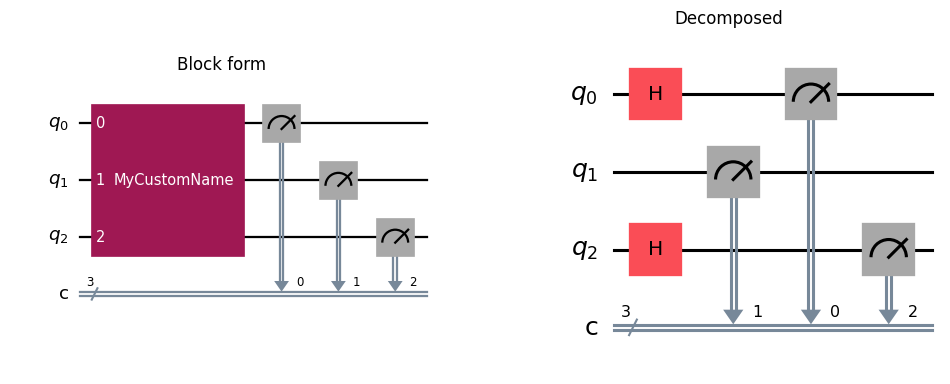

In [2]:
from qiskit import QuantumCircuit


class MyCustomBlock(CircuitBlock):
    """
    Adds a hadamard gate on every even qubit.
    """
    def __init__(self) -> None:
        super().__init__('MyCustomName')
        
    def _build_circuit(self, num_qubits: int) -> QuantumCircuit:
        circuit = QuantumCircuit(num_qubits)
        for i in range(num_qubits):
            if i % 2 == 0:
                circuit.h(i)
        return circuit

circ =  build_circuit(3,[MyCustomBlock()])

show_circuit(circ)

## Parameterized blocks (encoding blocks)

Parameterized blocks allow you to encode either the input vector or weights into the quantum circuit.  
The procedure for adding your own is largely the same, however `EncoderBlock` provides a convenience method `_create_parameters()` for creating uniquely named lists of parameters for you to use.

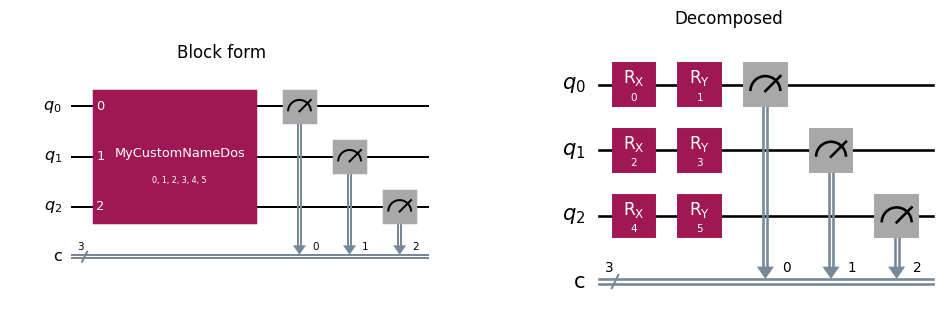

In [3]:
from typing import Literal


class MyCustomEncodingBlock(EncodingBlock):
    """
    Adds an Rx then an Ry gate to every qubit
    """
    def __init__(self, block_type: Literal['input','weight'] = 'input') -> None:
        super().__init__("MyCustomNameDos", block_type)
        
    def _build_circuit(self, num_qubits: int) -> QuantumCircuit:
        if self._parameters is None:
            self._parameters = self._create_parameters(2*num_qubits) #Initialize 2*num_qubits new parameters
        circuit = QuantumCircuit(num_qubits)
        for i in range(num_qubits):
            circuit.rx(self._parameters[2*i],i)
            circuit.ry(self._parameters[2*i+1],i)
            
        return circuit
    
circ =  build_circuit(3,[MyCustomEncodingBlock()])

show_circuit(circ.assign_parameters(list(range(len(circ.parameters))))) # Assign sample parameters, as without them draw() puts the entire name in the graph.

## Non-gate blocks

Some quantum circuits cannot be converted to gates (e.g circuits with measurements).  
If you create a block that cannot be converted to a gate, you can subclass `NonGateBlock`, which will change the way in which the block is added to a circuit.  
The drawback of this solution is that if the circuit has a lot of other gates, which can together be converted to a single gate, they will remain in their decomposed form. 

In [4]:
class MyCustomMeasurementBlock(CircuitBlock):
    """
    Adds a hadamard gate to every qubit, then measures only odd qubits.
    """
    def __init__(self) -> None:
        super().__init__('MyCustomNameTres')
        
    def _build_circuit(self, num_qubits: int) -> QuantumCircuit:
        circuit = QuantumCircuit(num_qubits,num_qubits//2) # Add classical bits for measurements
        clbit = 0
        for i in range(num_qubits):
            circuit.h(i)
            if i % 2 == 1:
                circuit.measure(i,clbit)
                clbit += 1
                
        return circuit

print("This will throw an error!")
try:
    circ = build_circuit(3,[MyCustomMeasurementBlock()],measure_qubits=[])
except Exception as e:
    print(f"!ERROR! {e}")

This will throw an error!
!ERROR! 'Circuit with classical bits cannot be converted to gate.'


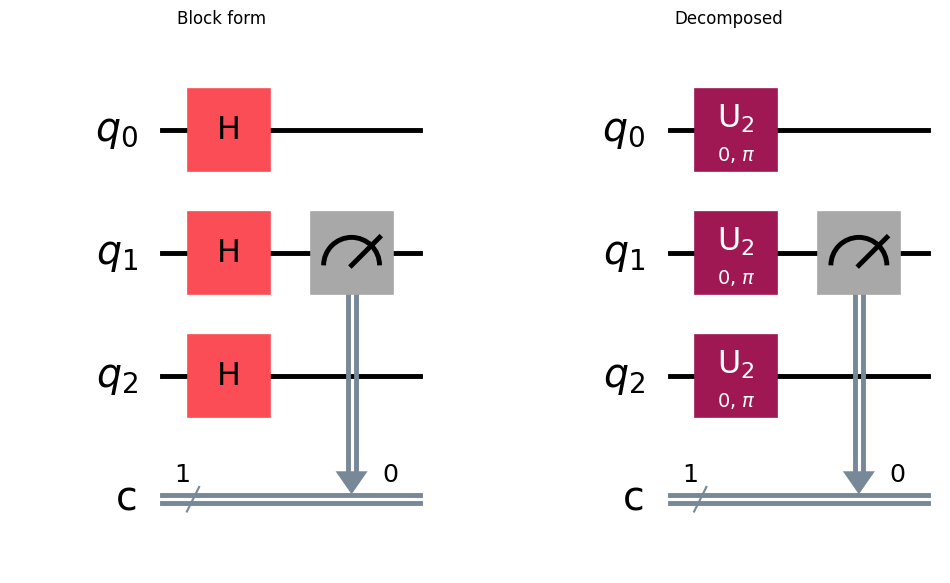

In [ ]:
class MyCustomMeasurementBlock(NonGateBlock,CircuitBlock):
    """
    Adds a hadamard gate to every qubit, then measures only odd qubits.
    """
    def __init__(self) -> None:
        super().__init__('MyCustomNameTres')
        
    def _build_circuit(self, num_qubits: int) -> QuantumCircuit:
        circuit = QuantumCircuit(num_qubits,num_qubits//2) # Add classical bits for measurements
        clbit = 0
        for i in range(num_qubits):
            circuit.h(i)
            if i % 2 == 1:
                circuit.measure(i,clbit)
                clbit += 1
                
        return circuit

circ = build_circuit(3,[MyCustomMeasurementBlock()],measure_qubits=[])
show_circuit(circ)

## Additional remarks

- Circuits created by your block can have more qubits than `num_qubits`. These additional qubits are treated as purely auxiliary and won't be measured by default.
- If two blocks create one auxiliary qubit each, the final circuit produced by `build_circuit` will have an additional 2 qubits.